In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = 'Times New Roman'
plt.rcParams['mathtext.default'] = 'regular'
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as clrs

# Load the viridis colorscale
viridis = cm.get_cmap('Spectral_r', 500)

def place_caption_label(ax, label, loc='upper left', Fontsize=35):
    from matplotlib.offsetbox import AnchoredText
    at = AnchoredText(label, loc=loc, prop=dict(size=Fontsize), frameon=True, borderpad = 0)
    ax.add_artist(at)
    return None

import matplotlib.patheffects as pe
from matplotlib.cm import ScalarMappable

# Prepare the color map 
cmap = cm.get_cmap('RdYlBu_r', 500)

# The cmap is an array with the colors
cmin = -50
cmax = 200
color_min = cmap(0)
color_max = cmap(500)
pos_0 = -cmin/(cmax-cmin)
color_0 = cmap(0.5)
cmap = clrs.LinearSegmentedColormap.from_list('custom diverging', 
                                             [(0,    color_min),
                                              (pos_0, color_0),
                                              (1,    color_max)], N=500)

In [38]:
# Load the 'true' DAPDs for Pharm protocol
loaded_Pharm = pd.read_csv('../Experimental data/Data for benchmark - Pharm.csv', delimiter = ',')

# Load the 'true' DAPDs for CiPA protocol
loaded_CiPA = pd.read_csv('../Experimental data/Data for benchmark - CiPA.csv', delimiter = ',')

# Function to compute the score
def score(simulated, true, sigma):
    return abs(np.power((simulated - true)/sigma, 1))

In [39]:
# Load the simulated DAPDs
model_names = ['Bartolucci_2020', 'Grandi_2010_endo', 'Grandi_Mann_endo', 'ORd_2011_Endo', 'ORd_CiPA', 
               'ORd_Krogh', 'ORd_Mann', 'Tomek_2020_Endo', 'TT06_Endo', 'TT06_Mann']

# Load the predictions for all the models
DAPD_Pharm = np.zeros((len(model_names), 29))
DAPD_CiPA = np.zeros((len(model_names), 29))

for m, model in enumerate(model_names):
    DAPD_Pharm[m, :] = np.loadtxt('Predictions/DAPD ' + model + '.mmt - Pharm.csv')
    DAPD_CiPA[m, :] = np.loadtxt('Predictions/DAPD ' + model + '.mmt - CiPA.csv')
    


In [40]:
drugs = ['Chlorpromazine', 'Clozapine', 'Dofetilide', 'Fluoxetine', 'Mesoridazine', 'Nifedipine', 'Quinidine', 'Thioridazine', 'Verapamil']

# Initialise the arrays
scores_Pharm = np.zeros((len(model_names), len(drugs)))
scores_CiPA = np.zeros((len(model_names), len(drugs)))

# Compute the score as total and for each drug
for m, model in enumerate(model_names):
    for d, drug in enumerate(drugs):
        # For Pharm
        # Find the corresponding data
        data_Pharm = loaded_Pharm[loaded_Pharm['Drug 1'] == drug]
        indices = np.array(data_Pharm.index)
        DAPD = np.array(data_Pharm['DAPD'])
        sigmas = np.array(data_Pharm['SEM'])
        
        # Account for all the datapoints
        for c in range(len(indices)):
            # Add the score corresponding to each drug condition
            scores_Pharm[m, d] += score(DAPD_Pharm[m, indices[c]], DAPD[c], sigmas[c])
            
        # For CiPA
        # Find the corresponding data
        data_CiPA = loaded_CiPA[loaded_CiPA['Drug 1'] == drug]
        indices = np.array(data_CiPA.index)
        DAPD = np.array(data_CiPA['DAPD'])
        sigmas = np.array(data_CiPA['SEM'])
        
        # Account for all the datapoints
        for c in range(len(indices)):
            # Add the score corresponding to each drug condition
            scores_CiPA[m, d] += score(DAPD_CiPA[m, indices[c]], DAPD[c], sigmas[c])
        


In [41]:
#np.vstack((np.sum(scores_Pharm, axis = 1), np.sum(scores_CiPA, axis = 1)))
avg_score = np.mean(np.vstack((np.sum(scores_Pharm, axis = 1), np.sum(scores_CiPA, axis = 1))), axis = 0)
np.argsort(avg_score)

array([8, 2, 1, 9, 5, 6, 7, 4, 0, 3], dtype=int64)

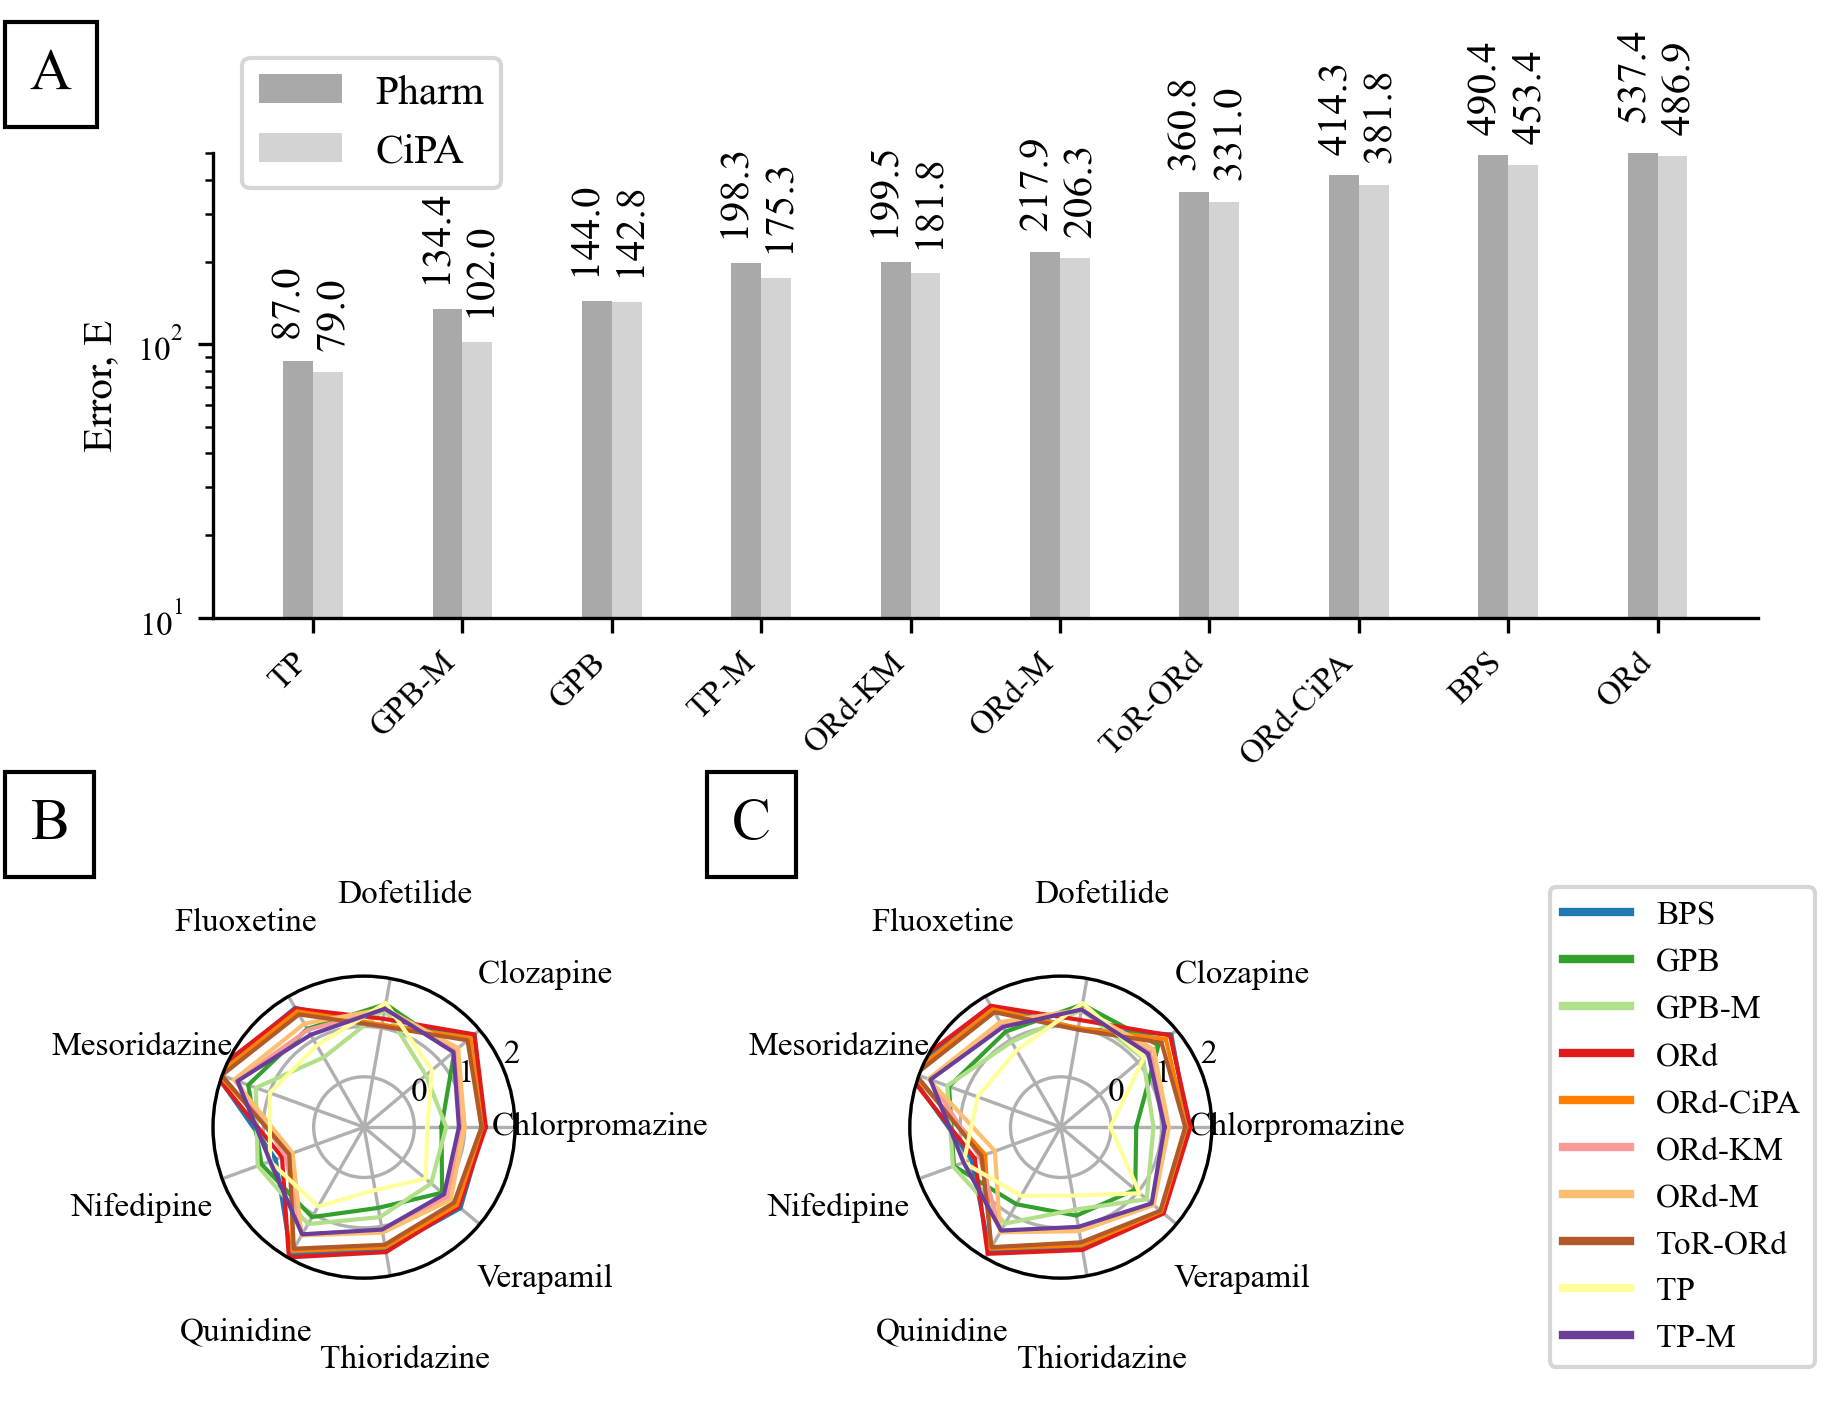

In [42]:
# Radar plot
fig, axes = plt.subplots(2, 3, figsize=(6, 5), subplot_kw={'projection': 'polar'}, gridspec_kw={'width_ratios':[1, 1, 0.5]})
fig.set_dpi(300)
fig.patch.set_facecolor('white')

# Fonts
labelsize = 10
ticksize = 8

# Ax for the benchmark outcomes
gs = axes[0, 0].get_gridspec()
for ax in axes[0, :]:
    ax.remove()
ax = fig.add_subplot(gs[0, :])

model_labels = ['BPS', 'GPB', 'GPB-M', 'ORd', 'ORd-CiPA', 'ORd-KM', 'ORd-M', 'ToR-ORd',
                'TP', 'TP-M']

plt.semilogy()

# Sort by average score
average_score = np.mean(np.vstack((np.sum(scores_Pharm, axis = 1), np.sum(scores_CiPA, axis = 1))), axis = 0)
indices = np.argsort(average_score)

# Axes and aesthetics
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.set_xlabel('Model', fontsize = labelsize)
ax.set_ylabel('Error, E', fontsize = labelsize)
ax.tick_params(labelsize = ticksize)
x = np.linspace(0, len(model_names) - 1, len(model_names))
ax.set_xticks(x)
ax.set_xticklabels([m for _, m in sorted(zip(average_score, model_labels))], rotation = 45, ha = 'right')
ax.set_ylim([10, 500])


# Add a text for the total score for each model
for i, indice in enumerate(indices):
    # Draw the stacked bar chart for the benchmark
    ax.bar(i-0.1, np.sum(scores_Pharm[indice]), width = 0.2, color = 'darkgrey')

    ax.bar(i+0.1, np.sum(scores_CiPA[indice]), width = 0.2, color = 'lightgray')
    
    # For Pharm
    ax.text(x = i-0.15, y = np.sum(scores_Pharm[indice]), s ='  ' + str(np.round(np.sum(scores_Pharm[indice]), decimals = 1)),
        rotation=90, va='bottom', ha = 'center', fontsize = labelsize)
    # For CiPA
    ax.text(x = i+0.15, y = np.sum(scores_CiPA[indice]), s = '  ' + str(np.round(np.sum(scores_CiPA[indice]), decimals = 1)),
        rotation=90, va='bottom', ha = 'center', fontsize = labelsize)
   
# Add legend
ax.bar(-0.1, np.sum(scores_Pharm[indices[0]]), width = 0.2, label='Pharm', color = 'darkgrey')
ax.bar(0.1, np.sum(scores_CiPA[indices[0]]), width = 0.2, label = 'CiPA', color = 'lightgray')
ax.legend(fontsize = labelsize, bbox_to_anchor=(0.05, 1.1, 0.15, 0.15))

# For CiPA
ax = axes[1, 0]
# Labels and axes
label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(drugs)+1)
ax.tick_params(pad = 10, labelsize = ticksize)
ax.set_thetagrids(np.degrees(label_loc[:-1]), labels=drugs, fontsize = ticksize)
ax.set_yticks([0, 1, 2, 3, 4])
ax.set_ylim(-1, 2)

# Color palette for dstinguishing the models
colors = ['#1f78b4','#33a02c','#b2df8a','#e31a1c','#ff7f00','#fb9a99','#fdbf6f','#b15928','#ffff99', '#6a3d9a','#cab2d6']

# Add the spider plot
for m, model in enumerate(model_labels):
    to_plot = list(np.log10(scores_CiPA[m])) + [np.log10(scores_CiPA[m, 0])]
    #ax.plot(label_loc, to_plot, label=model_labels[m], color = viridis(m / len(model_labels)))
    ax.plot(label_loc, to_plot, label=model_labels[m], color = colors[m], linewidth = 1)


# For Pharm
ax = axes[1, 1]
# Labels and axes
label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(drugs)+1)
ax.tick_params(pad = 10, labelsize = ticksize)
ax.set_thetagrids(np.degrees(label_loc[:-1]), labels=drugs, fontsize = ticksize)
ax.set_yticks([0, 1, 2, 3, 4])
ax.set_ylim(-1, 2)

# Add the spider plot
for m, model in enumerate(model_labels):
    to_plot = list(np.log10(scores_Pharm[m])) + [np.log10(scores_Pharm[m, 0])]
    #ax.plot(label_loc, to_plot, color = viridis(m / len(model_labels)))
    ax.plot(label_loc, to_plot, color = colors[m], linewidth = 1)


# Add the legend
ax = axes[1, 2]
ax.axis('off')
for m, models in enumerate(model_labels):
    #ax.plot([], label=model_labels[m], color = viridis(m / len(model_labels)))
    ax.plot([], label=model_labels[m], color = colors[m], linewidth = 2)
ax.legend(loc='center', fontsize = ticksize)

plt.figtext(0.01, 0.93, 'A', bbox = dict(edgecolor='k', facecolor = 'white', pad = 6), fontsize = 14)
plt.figtext(0.01, 0.43, 'B', bbox = dict(edgecolor='k', facecolor = 'white', pad = 6), fontsize = 14)
plt.figtext(0.4, 0.43, 'C', bbox = dict(edgecolor='k', facecolor = 'white', pad = 6), fontsize = 14)


# Save
plt.tight_layout()
plt.savefig('benchmark score.png', dpi = 300)
plt.savefig('benchmark score.pdf', format = 'pdf', transparent = True, bbox_inches = 'tight')

In [43]:
# For reference, if the model predicts 0 APD90 change
APD_zeros = np.sum(np.array(loaded_Pharm['DAPD']) / np.array(loaded_Pharm['SEM']))
print('A model which would predict 0 APD90 change over the whole map would have a score of: ' + str(APD_zeros))

A model which would predict 0 APD90 change over the whole map would have a score of: 58.98390853459026


In [44]:
print(scores_Pharm)
print(model_labels)
print(drugs)
print(scores_CiPA)

[[ 34.12117425  73.35598673   9.64122785  60.08947362 166.31220852
    7.71715518  67.48753217  27.88968994  43.75565398]
 [  3.15138256  33.97961415  29.76884954  15.48540452  23.02922697
   18.15026155   5.85624614   6.07867942   8.51996509]
 [  6.92901129  13.61671088  22.94158512   9.03810614  25.17581759
   18.98633396  16.25429666   4.59616319  16.88760052]
 [ 37.58032689  68.29160443  14.53489652  60.61917232 193.1257758
    6.5848175   80.41794911  30.00114668  46.2933238 ]
 [ 30.86255623  52.98061187   9.9939832   50.38117613 140.50080211
    3.97700954  61.22940467  24.15042849  40.20885461]
 [ 12.21371929  20.47831063  23.27589001  21.48352176  57.64764356
    5.22647071  24.68188668  10.88260532  23.60705541]
 [ 13.99856863  25.47751777  23.53220546  25.67751268  62.77955266
    2.47082761  25.88319247  12.53114413  25.57694156]
 [ 29.53950365  40.91796309   9.22609783  43.23589326 117.40057688
    4.73509916  56.5205424   21.02486488  38.19804743]
 [  0.97000714  14.352383

# Maps of errors in predictions

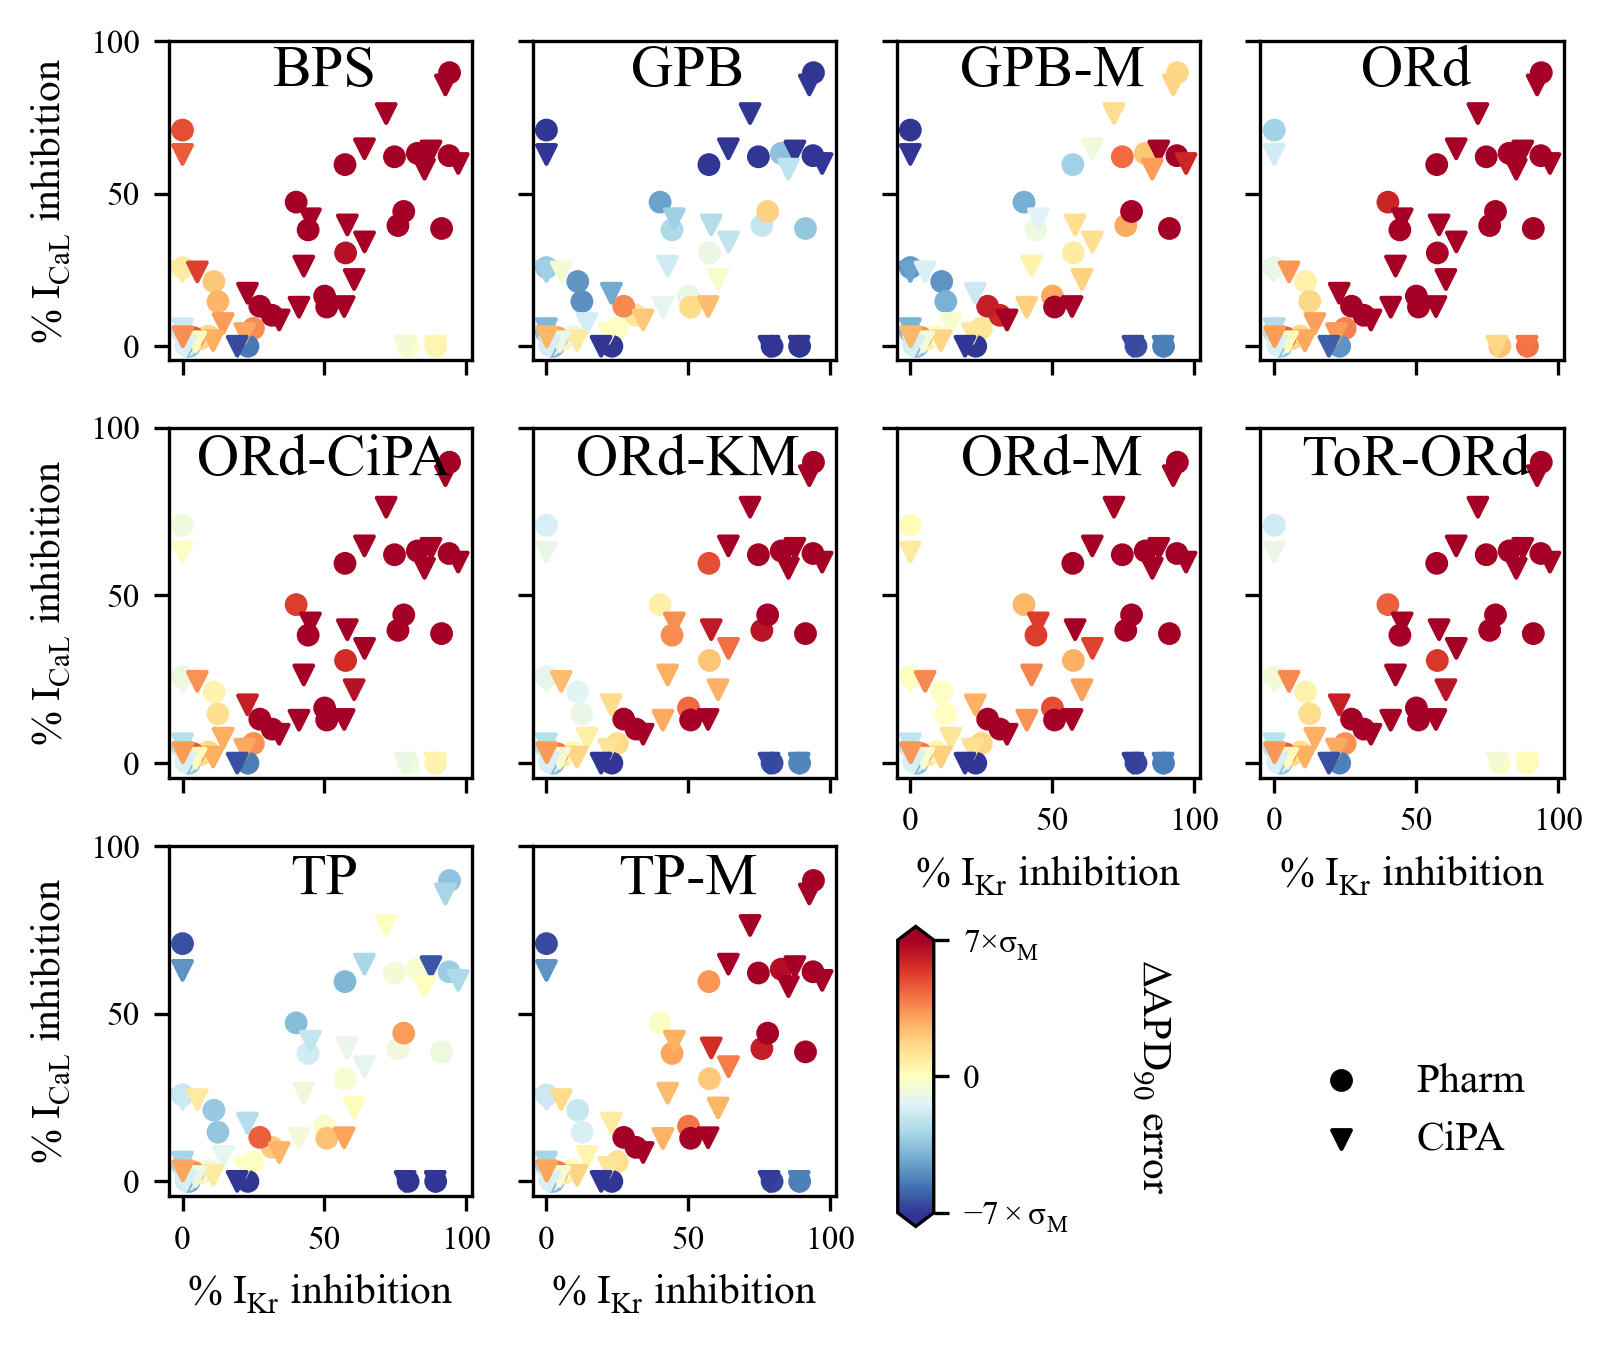

In [54]:
# Plot a map for each model of validated/invalidated predictions
fig, axes = plt.subplots(3, 4, figsize = (6, 5), gridspec_kw={'height_ratios':[1, 1.1, 1.1], 'width_ratios':[1, 1, 1, 1]})
fig.set_dpi(300)
fig.patch.set_facecolor('white')

# Fonts
labelsize = 10
ticksize = 8

# Define the colormap
cmap = cm.get_cmap('RdYlBu_r')

# Deduce the IKr/ICaL combinations for which the models are validated
for m, mod in enumerate(model_labels):
    ax = axes[m//4, m%4]
    
    # Add the validated cases
    # For Pharm
    c =  (DAPD_Pharm[m] - np.array(loaded_Pharm['DAPD'])) / np.array(loaded_Pharm['SEM'])
    ax.scatter(100*(1-np.array(loaded_Pharm['IKr block'])), 100*(1-np.array(loaded_Pharm['ICaL block'])), s=20, 
               cmap = cmap, c=c, norm = plt.Normalize(-7, 7))
    #print(np.sum(abs(c)))
        
    # For CiPA
    c =  (DAPD_CiPA[m] - np.array(loaded_CiPA['DAPD'])) / np.array(loaded_CiPA['SEM'])
    ax.scatter(100*(1-np.array(loaded_CiPA['IKr block'])), 100*(1-np.array(loaded_CiPA['ICaL block'])), s=20, 
               cmap =  cmap, c=c, norm = plt.Normalize(-7, 7), marker = 'v')
        
    # Axes
    ax.set_xticks([0, 50, 100])
    ax.set_yticks([0, 50, 100])
    ax.tick_params(labelsize = ticksize)
    if m < len(model_labels) - 4:
        ax.set_xticklabels(['', '', ''])
    else:
        ax.set_xlabel('% $\mathregular{I_{Kr}}$ inhibition', fontsize = labelsize)
    if m%4 > 0:
        ax.set_yticklabels(['', '', ''])
    else:
        ax.set_ylabel('% $\mathregular{I_{CaL}}$ inhibition', fontsize = labelsize)
        
    ax.text(50, 90, ha = 'center', va = 'center', s = model_labels[m], fontsize = 14)

# Add a legend
ax = axes[-1, -1]
ax.axis('off')
ax.scatter([], [], color = 'k', marker = 'o', s = 20, label = 'Pharm')
ax.scatter([], [], color = 'k', marker = 'v', s = 20, label = 'CiPA')
ax.legend(loc= 'lower center', fontsize = 10, framealpha = 0)

# Turn off the axes of axes after the last model and add colorbar
ax = axes[-1, -2]
cax = fig.add_axes([0.53, 0.09, 0.02, 0.2])

ax.axis('off')
norm = plt.Normalize(-7, 7)
sm =  ScalarMappable(norm=norm, cmap=cm.get_cmap('RdYlBu_r'))
sm.set_array([])

cbar = fig.colorbar(sm, extend = 'both', cax = cax)
cbar.set_ticks([-7, 0, 7])
cbar.ax.set_yticklabels([r'$-7 \times \sigma_M$', 0, r'7$\times \sigma_M$'], fontsize = ticksize)
cbar.set_label('$\Delta$APD$_{90}$ error', rotation=270, fontsize = labelsize, labelpad = 25)

# Get no pad between plots
#plt.tight_layout(pad = 0)

plt.savefig('Validation cases.png', dpi = 300)
plt.savefig('Validation cases.pdf', transparent=True, format = 'pdf', bbox_inches = 'tight')